In [8]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re, sys, json, warnings
from datetime import datetime
from pathlib import Path
from typing import List, Tuple
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [14]:
EXCEL_PATH = "rnv_data.xlsx" 
SHEET = "Ecommerce Customers"

### 1.Could you carry out an EDA analysis for the Ecommerce customers dataset?

#### EDA

In [16]:
# Columns used
NUM_COLS = ["Avg. Session Length","Time on App","Time on Website","Length of Membership","Yearly Amount Spent"]
TARGET = "Yearly Amount Spent"
FEATURES = [c for c in NUM_COLS if c != TARGET]

In [18]:
# One-liner: Load the sheet, normalize stray spaces in headers, preview basic shape and head.
df = pd.read_excel(EXCEL_PATH, sheet_name=SHEET)
df.columns = [c.strip() for c in df.columns]

print("Shape:", df.shape)
display(df.head(3))

# Missingness & dtypes overview
info_df = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "missing": df.isna().sum(),
    "missing_pct": (df.isna().mean()*100).round(2)
}).sort_values("missing", ascending=False)
display(info_df)

Shape: (500, 8)


,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,mstephenson@fernandez.com,"835 Frank Tunnel\nWrightmouth, MI 82180-9605",Violet,34.497268,12.655651,39.577668,4.082621,587.951054
1,hduke@hotmail.com,"4547 Archer Common\nDiazchester, CA 06566-8576",DarkGreen,31.926272,11.109461,37.268959,2.664034,392.204933
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582\nCobbborough, D...",Bisque,33.000915,11.330278,37.110597,4.104543,487.547505


,dtype,missing,missing_pct
Email,object,0,0.0
Address,object,0,0.0
Avatar,object,0,0.0
Avg. Session Length,float64,0,0.0
Time on App,float64,0,0.0
Time on Website,float64,0,0.0
Length of Membership,float64,0,0.0
Yearly Amount Spent,float64,0,0.0


,count,mean,std,min,25%,50%,75%,max
Avg. Session Length,500.0,33.053194,0.992563,29.532429,32.341822,33.082008,33.711985,36.139662
Time on App,500.0,12.052488,0.994216,8.508152,11.388153,11.983231,12.753850,15.126994
Time on Website,500.0,37.060445,1.010489,33.913847,36.349257,37.069367,37.716432,40.005182
Length of Membership,500.0,3.533462,0.999278,0.269901,2.930450,3.533975,4.126502,6.922689
Yearly Amount Spent,500.0,499.314038,79.314782,256.670582,445.038277,498.887875,549.313828,765.518462


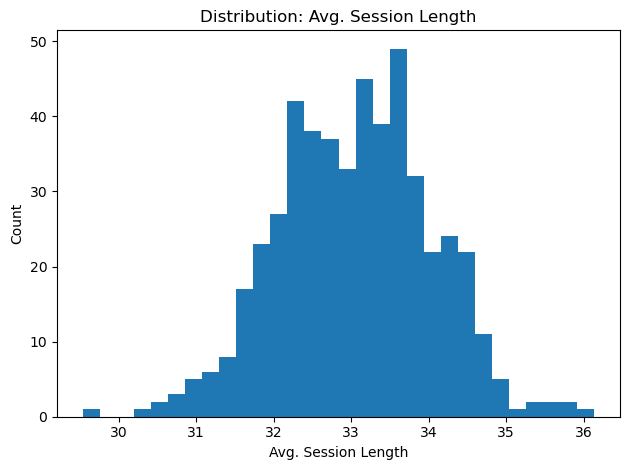

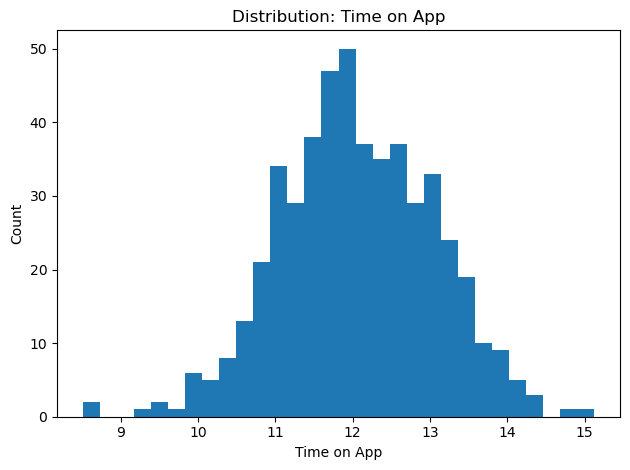

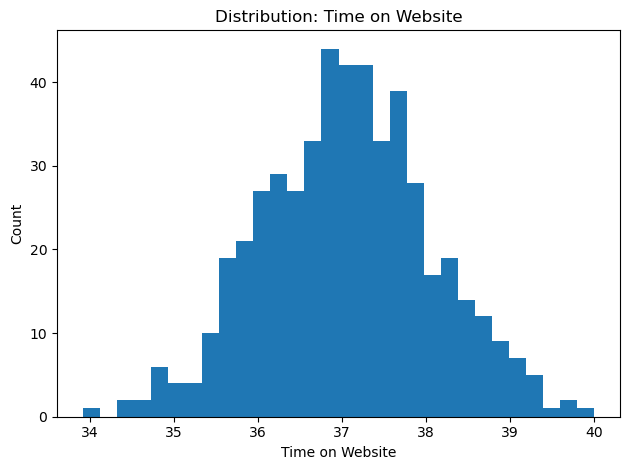

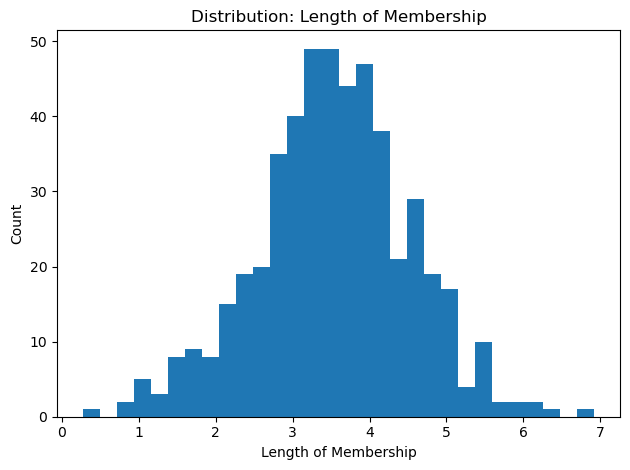

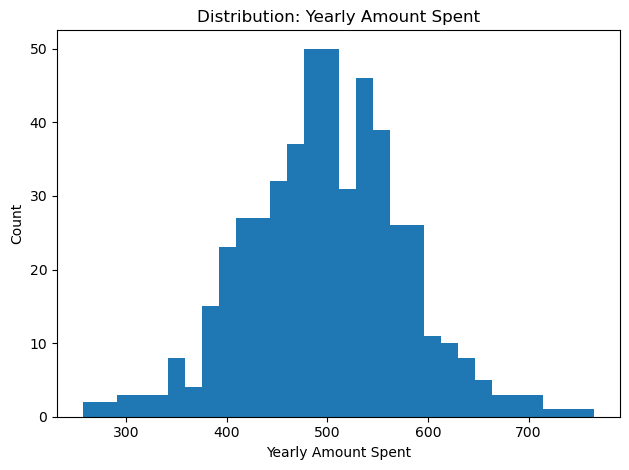

In [20]:
# One-liner: Summarize numeric columns and visualize distributions (histograms).
display(df[NUM_COLS].describe().T)

for c in NUM_COLS:
    plt.figure()
    plt.hist(df[c].dropna(), bins=30)
    plt.title(f"Distribution: {c}")
    plt.xlabel(c); plt.ylabel("Count"); plt.tight_layout()
    plt.savefig(OUT / f"hist_{c.replace(' ','_')}.png")
    plt.show()

,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
Avg. Session Length,1.000000,-0.027826,-0.034987,0.060247,0.355088
Time on App,-0.027826,1.000000,0.082388,0.029143,0.499328
Time on Website,-0.034987,0.082388,1.000000,-0.047582,-0.002641
Length of Membership,0.060247,0.029143,-0.047582,1.000000,0.809084
Yearly Amount Spent,0.355088,0.499328,-0.002641,0.809084,1.000000


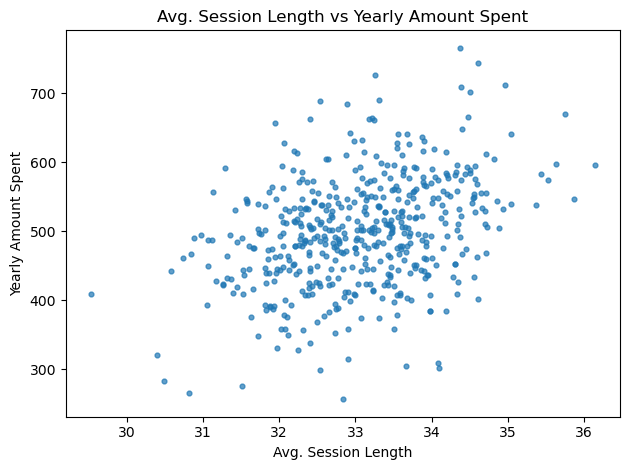

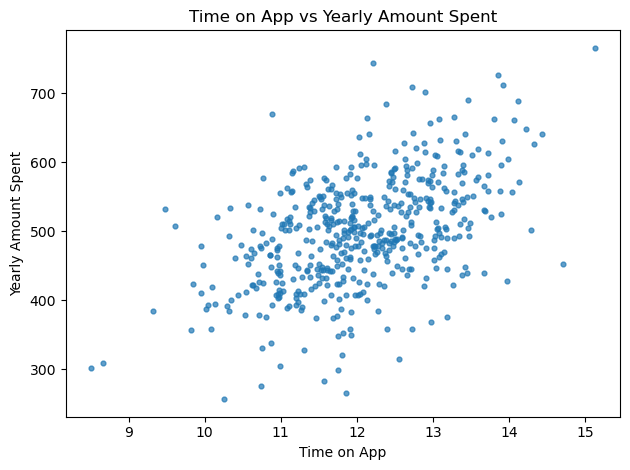

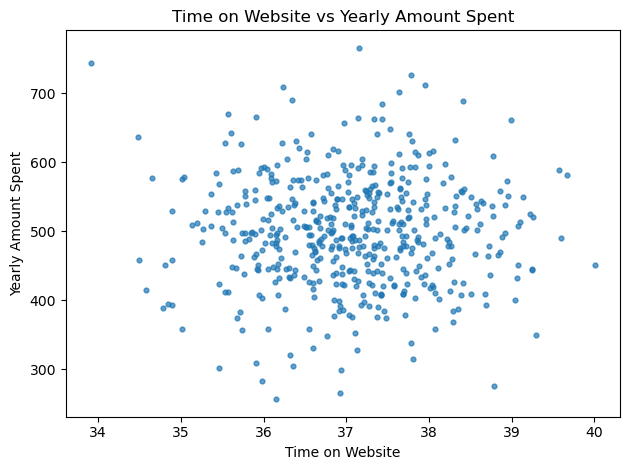

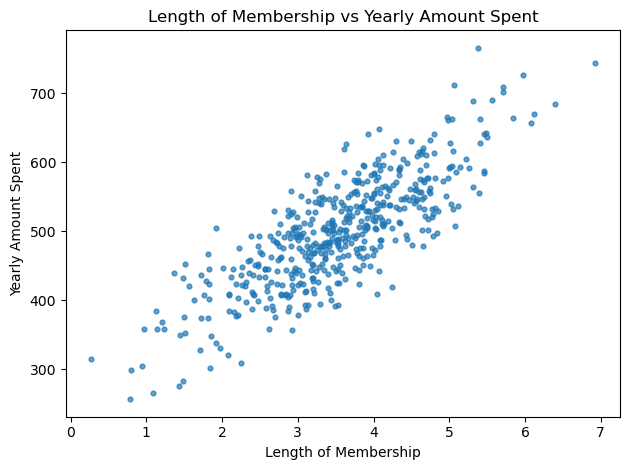

In [22]:
# One-liner: Compute correlation matrix and visualize feature-target relationships.
corr = df[NUM_COLS].corr()
display(corr)

for f in FEATURES:
    plt.figure()
    plt.scatter(df[f], df[TARGET], s=12, alpha=0.7)
    plt.title(f"{f} vs {TARGET}")
    plt.xlabel(f); plt.ylabel(TARGET); plt.tight_layout()
    plt.savefig(OUT / f"scatter_{f.replace(' ','_')}_vs_target.png")
    plt.show()

In [24]:
# One-liner: Count potential outliers per numeric column using the 1.5*IQR rule.
outlier_counts = {}
for c in NUM_COLS:
    q1, q3 = df[c].quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    outlier_counts[c] = int(((df[c] < lo) | (df[c] > hi)).sum())
pd.Series(outlier_counts, name="outliers").sort_values(ascending=False)

Length of Membership    12
Yearly Amount Spent      9
Time on App              4
Avg. Session Length      3
Time on Website          2
Name: outliers, dtype: int64

### 2.Could you try to create a regression model?

#### Regression Model

In [28]:
# One-liner: Train/test split and fit a simple Linear Regression baseline.

## Boosting methods can also be used here, but Linear Regression has been preferred due to the small data set. 
## Boosting methods are more suitable for larger data sets
X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

r2  = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Test R²:", round(r2,3), "  MAE:", round(mae,2), "  RMSE:", round(rmse,2))
print("Coefficients:", dict(zip(FEATURES, np.round(lr.coef_, 2))))
print("Intercept:", round(lr.intercept_, 2))

Test R²: 0.978   MAE: 8.56   RMSE: 10.48
Coefficients: {'Avg. Session Length': 25.6, 'Time on App': 38.79, 'Time on Website': 0.31, 'Length of Membership': 61.9}
Intercept: -1044.26


In [30]:
# One-liner: Standardize X and y to compare effect sizes across features.
X_std = (X - X.mean())/X.std(ddof=0)
y_std = (y - y.mean())/y.std(ddof=0)

Xtr_s, Xte_s, ytr_s, yte_s = train_test_split(X_std, y_std, test_size=0.2, random_state=42)
lr_std = LinearRegression(fit_intercept=False).fit(Xtr_s, ytr_s)
std_coefs = dict(zip(FEATURES, lr_std.coef_))
std_coefs_sorted = dict(sorted(std_coefs.items(), key=lambda kv: abs(kv[1]), reverse=True))

print("Standardized coefficients (β):")
for k,v in std_coefs_sorted.items():
    print(f"  {k}: {v:.3f}")

Standardized coefficients (β):
  Length of Membership: 0.780
  Time on App: 0.486
  Avg. Session Length: 0.320
  Time on Website: 0.004


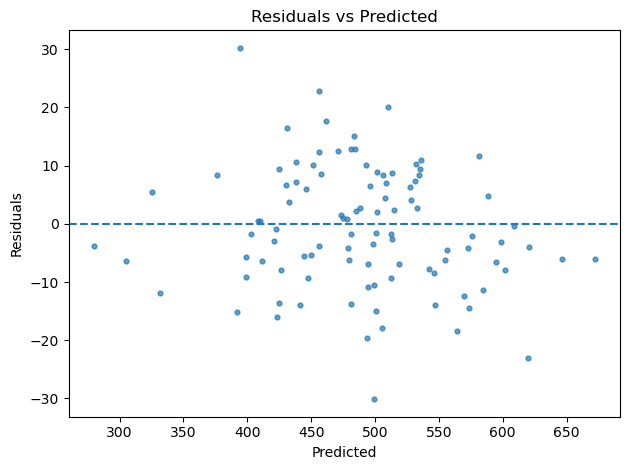

In [32]:
# One-liner: Quick residual check to ensure no gross violations (non-linearity, heteroskedasticity).
resid = y_test - y_pred

plt.figure()
plt.scatter(y_pred, resid, s=12, alpha=0.7)
plt.axhline(0, linestyle="--")
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted"); plt.ylabel("Residuals"); plt.tight_layout()
plt.savefig(OUT / "residuals_vs_predicted.png")
plt.show()

### 3.The CEO wants to decide if RNV should focus their efforts on the development of their mobile application or the website? Could you advise the CEO on where to focus his efforts?

In [35]:
# One-liner: Form a data-driven recommendation using standardized effects.
beta_app  = std_coefs.get("Time on App", np.nan)
beta_web  = std_coefs.get("Time on Website", np.nan)
beta_mem  = std_coefs.get("Length of Membership", np.nan)

focus = "mobile app" if abs(beta_app) >= abs(beta_web) else "website"

print("CEO advice:")
print(f"- Focus on the {focus}.")
print(f"- Standardized effects: Time on App β≈{beta_app:.3f}, Time on Website β≈{beta_web:.3f}, Length of Membership β≈{beta_mem:.3f}.")
print("- Invest in in-app engagement (personalization, faster checkout, notifications) and retention/loyalty to extend membership length.")
print("- Treat website improvements as hygiene/conversion fixes unless β for web surpasses app in future data.")


CEO advice:
- Focus on the mobile app.
- Standardized effects: Time on App β≈0.486, Time on Website β≈0.004, Length of Membership β≈0.780.
- Invest in in-app engagement (personalization, faster checkout, notifications) and retention/loyalty to extend membership length.
- Treat website improvements as hygiene/conversion fixes unless β for web surpasses app in future data.


In [37]:
# One-liner: Print short, copy-ready answers for the 3 questions.
print("Q1 — EDA:")
print("The dataset shows clean distributions and minimal missingness. Correlations with Yearly Amount Spent are strongest for Length of Membership and Time on App,")
print("while Time on Website is comparatively weaker; Avg. Session Length is positive. Plots (histograms/scatters) and a correlation matrix are included.")

print("\nQ2 — Regression:")
print(f"Baseline Linear Regression (80/20 split) yields R²={r2:.3f}, MAE={mae:.2f}, RMSE={rmse:.2f}.")
print("Standardized effects confirm Time on App and Length of Membership as the leading drivers; Time on Website is small.")

print("\nQ3 — CEO Advice:")
print(f"Focus on the mobile app and retention. Time on App (β≈{beta_app:.3f}) and Length of Membership (β≈{beta_mem:.3f}) dominate;")
print(f"Time on Website (β≈{beta_web:.3f}) is comparatively weak. Prioritize in-app engagement and loyalty; keep web improvements as hygiene.")


Q1 — EDA:
The dataset shows clean distributions and minimal missingness. Correlations with Yearly Amount Spent are strongest for Length of Membership and Time on App,
while Time on Website is comparatively weaker; Avg. Session Length is positive. Plots (histograms/scatters) and a correlation matrix are included.

Q2 — Regression:
Baseline Linear Regression (80/20 split) yields R²=0.978, MAE=8.56, RMSE=10.48.
Standardized effects confirm Time on App and Length of Membership as the leading drivers; Time on Website is small.

Q3 — CEO Advice:
Focus on the mobile app and retention. Time on App (β≈0.486) and Length of Membership (β≈0.780) dominate;
Time on Website (β≈0.004) is comparatively weak. Prioritize in-app engagement and loyalty; keep web improvements as hygiene.
